<a href="https://colab.research.google.com/github/andreagurioli1995/IoT-Air-Quality-Monitoring-System/blob/stable/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pandas
%pip install influxdb_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Data retrival from influx

In [ ]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
token = 'XcmfhaTm0yJzZhnThQBO26FZvYgtP0QJAocHVUucCoXcr9Vmymk69vOrJJ42_G03Y3h35KG0iapZM4dSE49AwQ=='
#bucket = $my-bucket
org = 'iot-org'
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [ ]:
query = 'from(bucket:"temperature")' \
        ' |> range(start:2007-12-10T15:00:00Z, stop:2016-01-20T15:00:00Z)'\
        ' |> filter(fn: (r) => r._measurement == "views")' \
        ' |> filter(fn: (r) => r._field == "y")'

In [ ]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

In [ ]:
raw = []
for table in result:
    for record in table.records:
        raw.append((record.get_value(), record.get_time()))
print("=== influxdb query into dataframe ===")
print()
df=pd.DataFrame(raw, columns=['y','ds'], index=None)
df['ds'] = df['ds'].values.astype('<M8[D]')
df.head()

In [ ]:
dataset_path = "/content/temp.csv"
df = pd.read_csv(dataset_path)
date_time = pd.to_datetime(df.pop('Time'), format='%Y-%m-%d %H:%M:%S')
df.rename(columns={'value {host="c8c9a3c96888", lat="44.59700012", lng="11.25300026"}':'temp'},inplace=True)

In [ ]:
df.head()

,temp
0,28.5
1,28.5
2,28.5
3,28.5
4,28.5


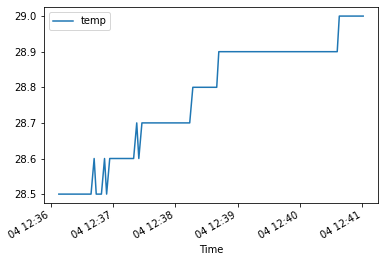

In [ ]:
#evolution over time of our data
plot_cols = ['temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,115.0,28.772174,0.162517,28.5,28.6,28.8,28.9,29.0


# Data preprocessing
In order to obtain a valuable model, time in string format is not useful, we need to convert it in seconds

In [ ]:
#converting timestamps form string to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
timestamp_s.head()

0    1.654346e+09
1    1.654346e+09
2    1.654346e+09
3    1.654346e+09
4    1.654346e+09
Name: Time, dtype: float64

Dealing with periodicity of the timestamps

In [ ]:
#how may seconds per day and year reported in sin and cos to obtain periodicity
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

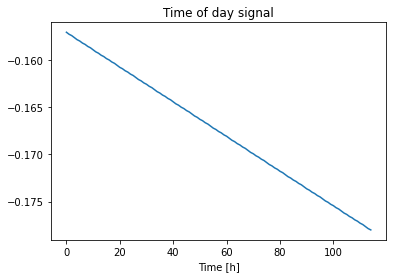

In [ ]:
plt.plot(np.array(df['Day sin']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of day signal')

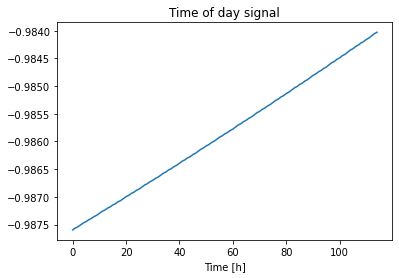

In [ ]:

plt.plot(np.array(df['Day cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
#splitting the dataset in training validating and testing set

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
#data normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

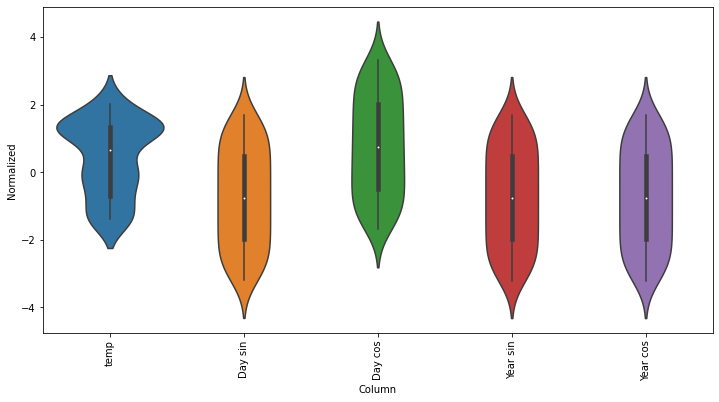

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

As we want to handle the input, we will use windowing for data input.
The main features of the input windows are:


*   The width (number of time steps) of the input and label windows.
*   The time offset between them
*    Which features are used as inputs, labels, or both.


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
#settle the length of the window for the prediction
window_length = 7
window_shift = 1
w1 = WindowGenerator(input_width=window_length, label_width=1, shift=window_shift,
                     label_columns=['temp'])
w1

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['temp']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[50:50+w1.total_window_size]),
                           np.array(train_df[70:70+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 5)
Inputs shape: (3, 7, 5)
Labels shape: (3, 1, 1)


In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

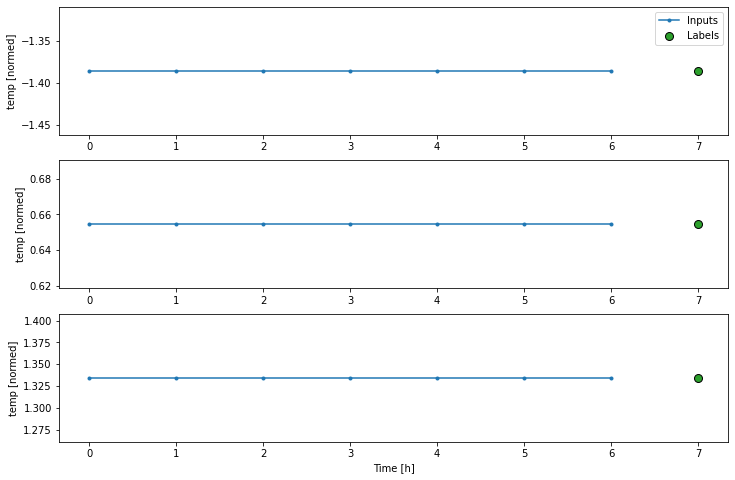

In [ ]:
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#Baseline model
Model wich predicts values by replicating the previous one

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['temp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

1/1 [==============================] - 1s 575ms/step - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']

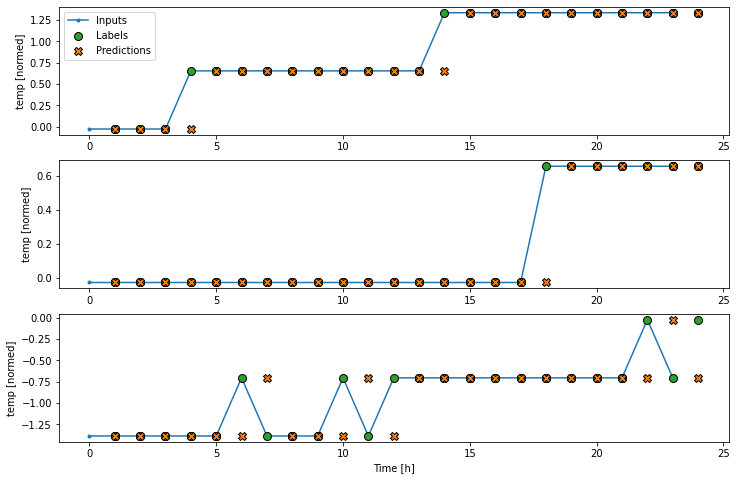

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
#val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
#performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 4s 57ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 2/20
2/2 [==============================] - 0s 59ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 3/20
2/2 [==============================] - 0s 61ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 4/20
2/2 [==============================] - 0s 76ms/step - loss: 0.0324 - mean_squared_error: 0.0324
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 0.0323 - mean_squared_error: 0.0323
Epoch 6/20
2/2 [==============================] - 0s 59ms/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 7/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 8/20
2/2 [==============================] - 0s 55ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 10/20
2/2 [====================

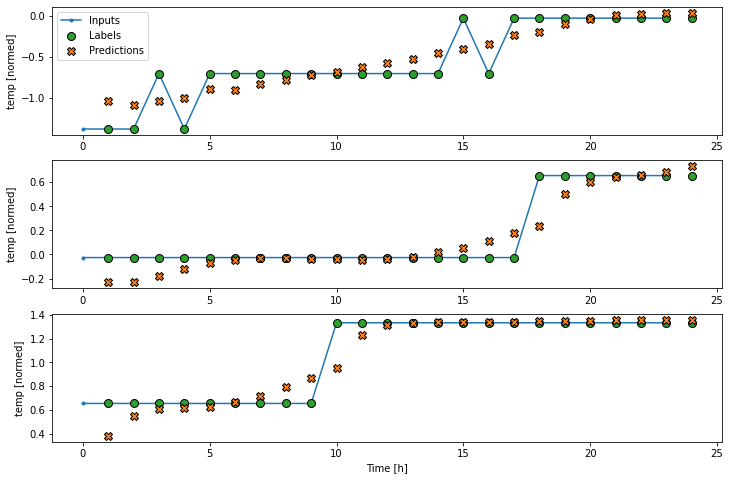

In [ ]:
wide_window.plot(lstm_model)